In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import zipfile
import os

In [103]:
# Extract the data zipped folder
zip_data = zipfile.ZipFile('/content/drive/MyDrive/לימודים/פרויקט גמר/oily-dry-normal.zip')
zip_data.extractall('/temp')
zip_data.close()
zip_data = zipfile.ZipFile('/content/drive/MyDrive/לימודים/פרויקט גמר/data.zip')
zip_data.extractall('/temp')
zip_data.close()

In [104]:
%%capture
!pip install torchinfo

# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# Preprocessing
from sklearn.model_selection import train_test_split

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# os
import os

# OrderedDict
from collections import OrderedDict

# tqdm
from tqdm.auto import tqdm

# Path
from pathlib import Path

# random
import random

# typing
from typing import Dict, List

# warnings
import warnings
warnings.filterwarnings("ignore")

In [105]:
def get_image_path_and_label_paires(data_path):
  IMAGE_PATH_LIST = list(Path(data_path).glob("*/*.jpg"))
  print(f'Total Images = {len(IMAGE_PATH_LIST)}')

  classes = os.listdir(Path(data_path))
  classes = sorted(classes)
  print("classes: ", classes)
  for c in classes:
    total_images_class = list(Path(os.path.join(Path(data_path), c)).glob("*.jpg"))
    print(f"* {c}: {len(total_images_class)} images")

  images_path = [None] * len(IMAGE_PATH_LIST)
  labels = [None] * len(IMAGE_PATH_LIST)

  for i,image_path in enumerate(IMAGE_PATH_LIST):
      images_path[i] = image_path
      labels[i] = image_path.parent.stem

  df_path_and_label = pd.DataFrame({'path':images_path,
                                    'label':labels})
  return df_path_and_label

paires= get_image_path_and_label_paires('/temp')
paires.head()

Total Images = 2837
classes:  ['Dark Circle', 'Dry Skin', 'Melasma', 'Normal Skin', 'Oily Skin', 'pustule', 'skin-pore', 'wrinkle']
* Dark Circle: 200 images
* Dry Skin: 455 images
* Melasma: 301 images
* Normal Skin: 221 images
* Oily Skin: 255 images
* pustule: 696 images
* skin-pore: 444 images
* wrinkle: 265 images


,path,label
0,/temp/Dry Skin/Kering-25-_jpeg_jpg.rf.b9d82a15...,Dry Skin
1,/temp/Dry Skin/berminyak__-21-_jpg.rf.cc617e9b...,Dry Skin
2,/temp/Dry Skin/Kering-14-_jpeg_jpg.rf.f6c6244a...,Dry Skin
3,/temp/Dry Skin/kering-48-_jpg.rf.f934699184c22...,Dry Skin
4,/temp/Dry Skin/kering__-89-_jpg.rf.74abbf818b9...,Dry Skin


In [106]:
# Shuffle
SEED=123

paires = paires.sample(frac=1, random_state=123)

train_paires, df_rest = train_test_split(paires,
                        test_size = 0.3,
                        random_state = SEED,
                        stratify = paires["label"])

valid_paires, test_paires = train_test_split(df_rest,
                      test_size = 0.5,
                      random_state = SEED,
                      stratify = df_rest["label"])

In [107]:
classes=['Dark Circle', 'Dry Skin', 'Melasma', 'Normal Skin', 'Oily Skin', 'pustule', 'skin-pore', 'wrinkle']
label_map = dict(zip(classes, range(0, len(classes))))
label_map

{'Dark Circle': 0,
 'Dry Skin': 1,
 'Melasma': 2,
 'Normal Skin': 3,
 'Oily Skin': 4,
 'pustule': 5,
 'skin-pore': 6,
 'wrinkle': 7}

In [108]:
weights = ViT_B_16_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [109]:
class CustomDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transforms, label_map:dict):
        self.df = df
        self.transforms = transforms
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        df_new = self.df.copy()
        df_new = df_new.reset_index(drop = True)
        df_new["label"] = df_new["label"].map(self.label_map)
        image_path = df_new.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)
        label = df_new.iloc[idx, 1]

        return image,label

In [110]:
train_dataset = CustomDataset(train_paires, auto_transforms, label_map)
valid_dataset = CustomDataset(valid_paires, auto_transforms, label_map)

In [111]:
BATCH_SIZE = 100
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)
valid_dataloader = DataLoader(dataset = valid_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)

In [112]:
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([100, 3, 224, 224]), torch.Size([100]))

In [113]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [114]:
model = vit_b_16(weights = weights)

In [115]:
summary(model = model,
        input_size = [1, 3, 224, 224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 1000]       768             True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] 590,592         True
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         True
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]   [1, 1

In [116]:
for param in model.conv_proj.parameters():
    param.requires_grad = False

In [117]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [118]:
summary(model = model,
        input_size = [1,3,224,224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 1000]       768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

In [119]:
output_shape = len(classes)

model.heads = nn.Sequential(
    OrderedDict([('head', nn.Linear(in_features = 768, out_features = output_shape))])
    )

In [120]:
summary(model = model,
        input_size = [1,3,224,224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 8]          768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

In [121]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [122]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer):

    model.train()

    train_loss = 0.
    train_accuracy = 0.

    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred_logit = model(X)
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        train_accuracy += accuracy_score(y.cpu().numpy(),
                                         y_pred_class.detach().cpu().numpy())

    train_loss = train_loss/len(dataloader)
    train_accuracy = train_accuracy/len(dataloader)

    return train_loss, train_accuracy

In [123]:
def save_checkpoint(filename, model, loss, epoch, optimizer, metric):
    state = {"filename":filename,
             "model":model.state_dict(),
             "loss":loss,
             "epoch":epoch,
             "optimizer":optimizer.state_dict(),
             "metric":metric}

    torch.save(state, filename)

In [124]:
def valid_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module):

    model.eval()

    valid_loss = 0.
    valid_accuracy = 0.

    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            y_pred_logit = model(X)
            loss = loss_fn(y_pred_logit, y)
            valid_loss += loss.item()

            y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
            y_pred_class = torch.argmax(y_pred_prob, dim = 1)

            valid_accuracy += accuracy_score(y.cpu().numpy(), y_pred_class.detach().cpu().numpy())

    valid_loss = valid_loss/len(dataloader)
    valid_accuracy = valid_accuracy/len(dataloader)

    return valid_loss, valid_accuracy

In [125]:
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          valid_dataloader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          epochs:int = 10):

    results = {"train_loss":[],
               "train_accuracy":[],
               "valid_loss":[],
               "valid_accuracy":[]}

    best_valid_loss = float("inf")

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model,
                                                dataloader = train_dataloader,
                                                loss_fn = loss_fn,
                                                optimizer = optimizer)

        valid_loss, valid_accuracy = valid_step(model = model,
                                                dataloader = valid_dataloader,
                                                loss_fn = loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            file_name = "best_model.pth"
            save_checkpoint(file_name, model, best_valid_loss, epoch, optimizer, valid_accuracy)

        if (epoch % 5) == 0:
          temp_file_name=f"model_epoch_{epoch}.pth"
          print("saved file: " + temp_file_name)
          save_checkpoint(temp_file_name, model, best_valid_loss, epoch, optimizer, valid_accuracy)

        print(f"Epoch: {epoch + 1} | ",
              f"Train Loss: {train_loss:.4f} | ",
              f"Train Accuracy: {train_accuracy:.4f} | ",
              f"Valid Loss: {valid_loss:.4f} | ",
              f"Valid Accuracy: {valid_accuracy:.4f}")

        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["valid_loss"].append(valid_loss)
        results["valid_accuracy"].append(valid_accuracy)

    return results

In [126]:
# Training!!!
EPOCHS = 15

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

MODEL_RESULTS = train(model.to(device),
                      train_dataloader,
                      valid_dataloader,
                      loss_fn,
                      optimizer,
                      EPOCHS)

  0%|          | 0/15 [00:00<?, ?it/s]

saved file: model_epoch_0.pth
Epoch: 1 |  Train Loss: 0.6344 |  Train Accuracy: 0.7784 |  Valid Loss: 0.5386 |  Valid Accuracy: 0.8472
Epoch: 2 |  Train Loss: 0.2738 |  Train Accuracy: 0.9060 |  Valid Loss: 0.4394 |  Valid Accuracy: 0.8558
Epoch: 3 |  Train Loss: 0.1778 |  Train Accuracy: 0.9358 |  Valid Loss: 0.3962 |  Valid Accuracy: 0.8575
Epoch: 4 |  Train Loss: 0.1191 |  Train Accuracy: 0.9652 |  Valid Loss: 0.3885 |  Valid Accuracy: 0.8846
Epoch: 5 |  Train Loss: 0.0989 |  Train Accuracy: 0.9718 |  Valid Loss: 0.3832 |  Valid Accuracy: 0.8963
saved file: model_epoch_5.pth
Epoch: 6 |  Train Loss: 0.0867 |  Train Accuracy: 0.9764 |  Valid Loss: 0.3935 |  Valid Accuracy: 0.8849
Epoch: 7 |  Train Loss: 0.0814 |  Train Accuracy: 0.9726 |  Valid Loss: 0.3786 |  Valid Accuracy: 0.8983
Epoch: 8 |  Train Loss: 0.0616 |  Train Accuracy: 0.9862 |  Valid Loss: 0.4319 |  Valid Accuracy: 0.8846
Epoch: 9 |  Train Loss: 0.0501 |  Train Accuracy: 0.9890 |  Valid Loss: 0.4113 |  Valid Accuracy: 0.

In [127]:
def loss_metric_curve_plot(model_results:Dict[str,List[float]]):

    train_loss = model_results["train_loss"]
    valid_loss = model_results["valid_loss"]

    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    valid_accuracy = [float(value) for value in model_results["valid_accuracy"]]

    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    axes = axes.flat

    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(valid_loss, color = "blue", label = "Valid")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()

    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(valid_accuracy, color = "blue", label = "Valid")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()

    fig.tight_layout()
    fig.show()

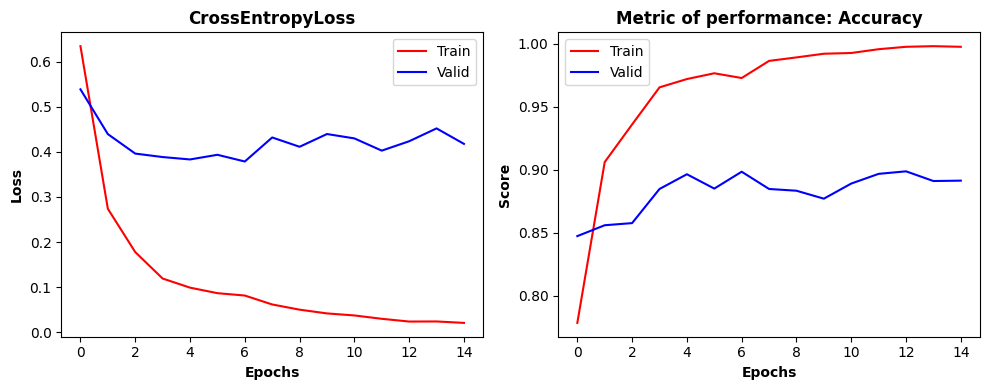

In [128]:
loss_metric_curve_plot(MODEL_RESULTS)

# Load The Model
Load the model from `best_model.pth`

In [129]:
checkpoint = torch.load("best_model.pth")
print(f'Best Loss: {checkpoint["loss"]}')
print(f'Epoch: {checkpoint["epoch"] + 1}')
print(f'Best Metric: {checkpoint["metric"]}')

Best Loss: 0.37861480712890627
Epoch: 7
Best Metric: 0.8983076923076923


In [130]:
test_dataset = CustomDataset(test_paires, auto_transforms, label_map)
test_dataloader = DataLoader(dataset = test_dataset, shuffle = False, num_workers = NUM_WORKERS)

In [131]:
loaded_model = vit_b_16()

loaded_model.heads = nn.Sequential(OrderedDict([('head',nn.Linear(in_features = 768,
                                                                  out_features = output_shape))]))

loaded_model.load_state_dict(checkpoint["model"])

# We now infer
loaded_model.to(device)

loaded_model.eval()

y_pred_test = []

with torch.inference_mode():
    for X,y in tqdm(test_dataloader):
        X,y = X.to(device), y.to(device)
        y_pred_logit = loaded_model(X)
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        y_pred_test.append(y_pred_class.detach().cpu())

  0%|          | 0/426 [00:00<?, ?it/s]

In [132]:
y_pred_test = torch.cat(y_pred_test).numpy()

In [133]:
print(f'Accuracy = {round(accuracy_score(test_paires["label"].map(label_map), y_pred_test), 4)}')

Accuracy = 0.8826


In [134]:
confusion_matrix_test = confusion_matrix(test_paires["label"].map(label_map), y_pred_test)

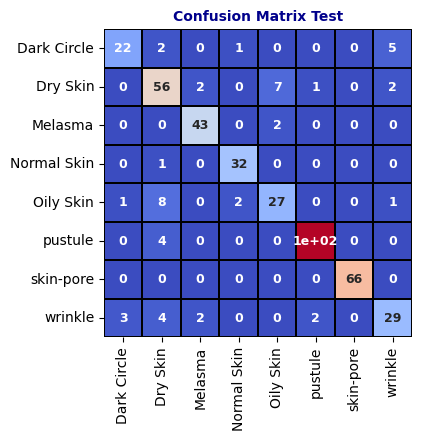

In [135]:
fig,ax = plt.subplots(figsize = (15,4))
sns.heatmap(confusion_matrix_test,
            cmap = 'coolwarm',
            annot = True,
            annot_kws = {"fontsize":9, "fontweight":"bold"},
            linewidths = 1.2,
            linecolor = "black",
            square = True,
            xticklabels = classes,
            yticklabels = classes,
            cbar = False,
            ax = ax)
ax.set_title("Confusion Matrix Test", fontsize = 10, fontweight = "bold", color = "darkblue")
ax.tick_params('x',rotation = 90)
fig.show()


In [136]:
# !pip install onnx
# !pip install onnxscript

loaded_model = vit_b_16()

loaded_model.heads = nn.Sequential(OrderedDict([('head',nn.Linear(in_features = 768,
                                                                  out_features = output_shape))]))

loaded_model.load_state_dict(checkpoint["model"])

dummy_input = torch.randn(1, 3, 224, 224)

# Export the model to ONNX format
torch.onnx.export(loaded_model, dummy_input, "/content/drive/MyDrive/לימודים/פרויקט גמר/model.onnx",
input_names=['input'], output_names=['output'],
dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})



Exception ignored in: <function tqdm.__del__ at 0x7f0befed31c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.10/dist-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


In [137]:
def test_on_data(path_to_zip_data):
  !rm -rf /temp-faces
  zip_data = zipfile.ZipFile(path_to_zip_data)
  zip_data.extractall('/temp-faces')
  zip_data.close()
  paires= get_image_path_and_label_paires('/temp-faces')
  print(paires.head())

  dataset = CustomDataset(paires, auto_transforms, label_map)
  dataloader = DataLoader(dataset = dataset, shuffle = False, num_workers = NUM_WORKERS)

  loaded_model = vit_b_16()

  loaded_model.heads = nn.Sequential(OrderedDict([('head',nn.Linear(in_features = 768,
                                                                    out_features = output_shape))]))

  loaded_model.load_state_dict(checkpoint["model"])

  # We now infer yael's face
  loaded_model.to(device)

  loaded_model.eval()

  y_pred_test = []

  with torch.inference_mode():
      for X,y in tqdm(dataloader):
          X,y = X.to(device), y.to(device)
          y_pred_logit = loaded_model(X)
          y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
          y_pred_class = torch.argmax(y_pred_prob, dim = 1)
          y_pred_test.append(y_pred_class.detach().cpu())

  y_pred_test = torch.cat(y_pred_test).numpy()
  print(y_pred_test)
  print(f'Accuracy = {round(accuracy_score(paires["label"].map(label_map), y_pred_test), 4)}')

In [138]:
test_on_data('/content/drive/MyDrive/לימודים/פרויקט גמר/yael-face.zip')

Total Images = 9
classes:  ['Normal Skin']
* Normal Skin: 9 images
                            path        label
0  /temp-faces/Normal Skin/1.jpg  Normal Skin
1  /temp-faces/Normal Skin/4.jpg  Normal Skin
2  /temp-faces/Normal Skin/3.jpg  Normal Skin
3  /temp-faces/Normal Skin/6.jpg  Normal Skin
4  /temp-faces/Normal Skin/2.jpg  Normal Skin


  0%|          | 0/9 [00:00<?, ?it/s]

[0 0 0 5 5 7 7 1 7]
Accuracy = 0.0


In [139]:
test_on_data('/content/drive/MyDrive/לימודים/פרויקט גמר/shahar-face.zip')

Total Images = 3
classes:  ['Normal Skin']
* Normal Skin: 3 images
                            path        label
0  /temp-faces/Normal Skin/1.jpg  Normal Skin
1  /temp-faces/Normal Skin/3.jpg  Normal Skin
2  /temp-faces/Normal Skin/2.jpg  Normal Skin


  0%|          | 0/3 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0befc8dc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


[0 1 5]
Accuracy = 0.0
